In [1]:
import torch
import load_dataset
import torchaudio
import torchaudio.functional as F
# load the cnn model with pytorch
path = 'models/model_base.ckpt'
model = load_dataset.CNN()
model.load_state_dict(torch.load(path))
# load the audio file
image = load_dataset.load_dataset('../../sound-propagation-simulation/dataset_real_data/v3/test/')
#image = load_dataset.load_dataset('patch-attack-data/')
img_number = 1
waveform = image['waveforms'][img_number]
label = image['labels'][img_number]
print('true',label,end=' prediction ')
labels_to_int = {0: 'right_to_left', 1: 'left_to_right', 2: 'multiple_cars', 3: 'no_car'}
# convert the audio file to spectrogram
spectrogram = F.spectrogram(waveform, pad=0, window=torch.hann_window(1000), n_fft=1000, hop_length=1280, win_length=1000, power=2.0, normalized=True)
# add a dimension to the spectrogram
spectrogram = spectrogram.unsqueeze(0)
model.eval()
# predict the label
output = model(spectrogram)
# get the index of the highest value
a, predicted = torch.max(output[0], 1)
print(labels_to_int[predicted.item()], a)

number of label: 4
true left_to_right prediction left_to_right tensor([2.7366], grad_fn=<MaxBackward0>)


(tensor([[ -4.5388,   2.7366, -16.4222,  -2.7595]], grad_fn=<AddmmBackward0>), tensor([[ 9.8529,  9.7489, 10.7942,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<ViewBackward0>))
True label: 3
Predicted label: 3
no_car tensor([28.4282], grad_fn=<MaxBackward0>)


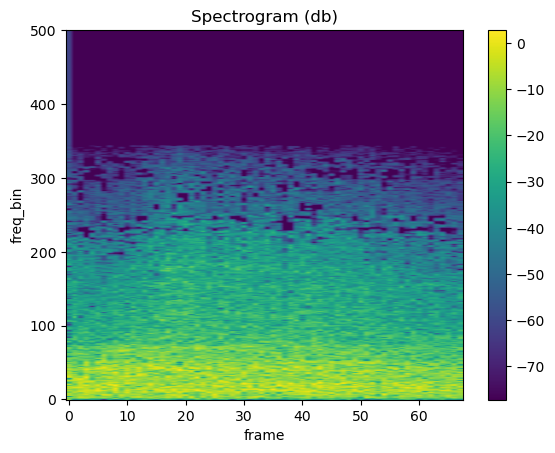

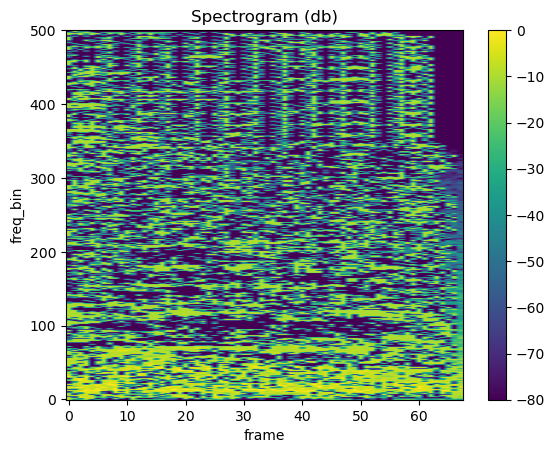

AttributeError: 'Tensor' object has no attribute 'complex'

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

# define the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
epsilon = -.1
input_tensor = spectrogram
label = torch.tensor([3])
input_tensor.requires_grad = True
output = model(input_tensor)
print(output)
loss = criterion(output[0], label)
loss.backward()
sign_data_grad = input_tensor.grad.sign()
perturbed_input_tensor = input_tensor + epsilon * sign_data_grad
perturbed_input_tensor = torch.clamp(perturbed_input_tensor, 0, 1)
output = model(perturbed_input_tensor)
a, predicted = torch.max(output[0], 1)

print('True label:', label.item())
print('Predicted label:', predicted.item())
print(labels_to_int[predicted.item()], a)

# plot the base spectrogram and the perturbed spectrogram
load_dataset.plot_spectrogram(spectrogram.detach().numpy()[0][0])
load_dataset.plot_spectrogram(perturbed_input_tensor.detach().numpy()[0][0])

recovered_waveform = torchaudio.transforms.InverseSpectrogram()(perturbed_input_tensor.detach().complex())
torchaudio.save('patch-attack-data/patch-attack.wav', waveform, 16000)